In [1]:
# FinAssist Repo
import os

REPO_URL = "https://github.com/MM24J/FinAssist.git"
REPO_PATH = "/content/FinAssist"

# Clone if missing
if not os.path.exists(REPO_PATH):
    !git clone {REPO_URL} {REPO_PATH}

# Enter repo and pull latest
%cd {REPO_PATH}
!git pull origin main

# Show structure
print("\n Repo contents:")
!ls -l
print("\n Data folder:")
!ls -l data || echo " Missing data folder"
print("\n Notebooks folder:")
!ls -l notebooks || echo " Missing notebooks folder"

# Default to notebooks folder
%cd notebooks

Cloning into '/content/FinAssist'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 31 (delta 9), reused 9 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 108.67 KiB | 1.45 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/FinAssist
From https://github.com/MM24J/FinAssist
 * branch            main       -> FETCH_HEAD
Already up to date.

 Repo contents:
total 16
drwxr-xr-x 2 root root 4096 Aug 25 19:34 data
drwxr-xr-x 2 root root 4096 Aug 25 19:34 finassist
drwxr-xr-x 2 root root 4096 Aug 25 19:34 notebooks
-rw-r--r-- 1 root root   11 Aug 25 19:34 README.md

 Data folder:
total 56
-rw-r--r-- 1 root root   332 Aug 25 19:34 Budget.csv
-rw-r--r-- 1 root root 50598 Aug 25 19:34 personal_transactions.csv

 Notebooks folder:
total 188
-rw-r--r-- 1 root root 189217 Aug 25 19:34 FinAssist_Project.ipynb
/content/FinAssist/notebooks


In [15]:
!pip -q install sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 42.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

# Correct path to data files
budget = pd.read_csv("../data/Budget.csv")
tx = pd.read_csv("../data/personal_transactions.csv", parse_dates=["Date"])

# Normalize helpers
tx["Type"] = np.where(tx["Amount"] >= 0, "Income", "Expense")
tx["Spend"] = tx["Amount"].where(tx["Amount"] < 0, 0).abs()
tx["Month"] = tx["Date"].dt.to_period("M").astype(str)

budget.head(), tx.head()

(                 Category  Budget
 0          Alcohol & Bars      50
 1          Auto Insurance      75
 2            Coffee Shops      15
 3  Electronics & Software       0
 4           Entertainment      25,
         Date          Description   Amount Transaction Type  \
 0 2018-01-01               Amazon    11.11            debit   
 1 2018-01-02     Mortgage Payment  1247.44            debit   
 2 2018-01-02      Thai Restaurant    24.22            debit   
 3 2018-01-03  Credit Card Payment  2298.09           credit   
 4 2018-01-04              Netflix    11.76            debit   
 
               Category   Account Name    Type  Spend    Month  
 0             Shopping  Platinum Card  Income    0.0  2018-01  
 1      Mortgage & Rent       Checking  Income    0.0  2018-01  
 2          Restaurants    Silver Card  Income    0.0  2018-01  
 3  Credit Card Payment  Platinum Card  Income    0.0  2018-01  
 4        Movies & DVDs  Platinum Card  Income    0.0  2018-01  )

In [4]:
# Normalize case spaces in Transaction Type column

tx["Transaction Type"] = tx["Transaction Type"].str.strip().str.lower()

# Drop categories categories not in "Budget" CSV

EXCLUDE_CATS = {"Food & Dining", "Paycheck", "Credit Card Payment"}
tx = tx[~tx["Category"].isin(EXCLUDE_CATS)]

# Use transaction type to determine spend

tx["Spend"] = np.where(tx["Transaction Type"] == "debit", tx["Amount"].astype(float), 0.0)
tx["Income"] = np.where(tx["Transaction Type"] == "credit", tx["Amount"].astype(float), 0.0)

# Month Helper

tx["Month"] = tx["Date"].dt.to_period("M").astype(str)

# Check which months have spend

month_spend = tx.groupby("Month")["Spend"].sum().sort_index()
print(month_spend.tail(12))

Month
2018-10     2227.62
2018-11     2118.15
2018-12     2589.94
2019-01     1736.43
2019-02     1954.60
2019-03     2142.59
2019-04     1966.87
2019-05     2253.41
2019-06    10912.38
2019-07     2551.12
2019-08     2043.20
2019-09     2038.28
Name: Spend, dtype: float64


/tmp/ipython-input-3101736426.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx["Spend"] = np.where(tx["Transaction Type"] == "debit", tx["Amount"].astype(float), 0.0)
/tmp/ipython-input-3101736426.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx["Income"] = np.where(tx["Transaction Type"] == "credit", tx["Amount"].astype(float), 0.0)
/tmp/ipython-input-3101736426.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [5]:
print(set(tx["Category"]))

{'Movies & DVDs', 'Utilities', 'Groceries', 'Entertainment', 'Restaurants', 'Electronics & Software', 'Music', 'Television', 'Haircut', 'Fast Food', 'Auto Insurance', 'Mortgage & Rent', 'Alcohol & Bars', 'Home Improvement', 'Gas & Fuel', 'Coffee Shops', 'Mobile Phone', 'Internet', 'Shopping'}


In [6]:
# Monthly Budget Report Header

from datetime import datetime

def human_month(ym):  # "2019-09" -> "September 2019"
    return datetime.strptime(ym, "%Y-%m").strftime("%B %Y")

# Monthly Budget Report Header
def month_report(month: str):
    # Sum up actual spend by category for the chosen month
    actuals = (tx[tx["Month"] == month]
               .groupby("Category", as_index=False)["Spend"].sum()
               .rename(columns={"Spend": "Actual"}))

    # Merge with budget and compute variance
    rep = (budget.merge(actuals, on="Category", how="left")
                  .fillna({"Actual": 0.0}))
    rep["Variance"] = rep["Actual"] - rep["Budget"]
    return rep.sort_values("Variance", ascending=False)

# Example use
rep = month_report("2019-09")
display(rep.head(10))
print(f"Total spend in {human_month('2019-09')}: ${rep['Actual'].sum():,.2f}")

,Category,Budget,Actual,Variance
0,Alcohol & Bars,50,72.98,22.98
15,Restaurants,150,172.34,22.34
1,Auto Insurance,75,75.00,0.00
12,Mortgage & Rent,1100,1100.00,0.00
3,Electronics & Software,0,0.00,0.00
11,Mobile Phone,65,65.00,0.00
10,Internet,75,75.00,0.00
13,Movies & DVDs,0,0.00,0.00
14,Music,11,10.69,-0.31
17,Television,15,13.90,-1.10


Total spend in September 2019: $2,038.28


In [7]:
# Over/Under Budget Summary

from datetime import datetime

def human_month(ym: str) -> str:
    # If it's already human (e.g., "September 2019"), just return it
    try:
        return datetime.strptime(ym, "%Y-%m").strftime("%B %Y")
    except Exception:
        return ym

def budget_summary(rep, top=5, month_label="(month)"):
    # Ensure nice month label
    month_label = human_month(month_label)

    over = rep[rep["Variance"] > 0].sort_values("Variance", ascending=False).head(top)
    under = rep[rep["Variance"] < 0].sort_values("Variance", ascending=True).head(top)

    print(f"--- Budget Summary for {month_label} ---\n")

    print("Top over-budget categories:")
    for r in over.itertuples():
        print(f"  - {r.Category}: +${r.Variance:,.2f} "
              f"(Actual ${r.Actual:,.2f} vs Budget ${r.Budget:,.2f})")

    print("\nTop under-budget categories:")
    for r in under.itertuples():
        print(f"  - {r.Category}: ${r.Variance:,.2f} "
              f"(Actual ${r.Actual:,.2f} vs Budget ${r.Budget:,.2f})")

In [8]:
rep = month_report("2019-09")
budget_summary(rep, month_label="September 2019")

--- Budget Summary for September 2019 ---

Top over-budget categories:
  - Alcohol & Bars: +$22.98 (Actual $72.98 vs Budget $50.00)
  - Restaurants: +$22.34 (Actual $172.34 vs Budget $150.00)

Top under-budget categories:
  - Home Improvement: $-223.75 (Actual $26.25 vs Budget $250.00)
  - Haircut: $-30.00 (Actual $0.00 vs Budget $30.00)
  - Entertainment: $-25.00 (Actual $0.00 vs Budget $25.00)
  - Utilities: $-25.00 (Actual $125.00 vs Budget $150.00)
  - Fast Food: $-15.00 (Actual $0.00 vs Budget $15.00)


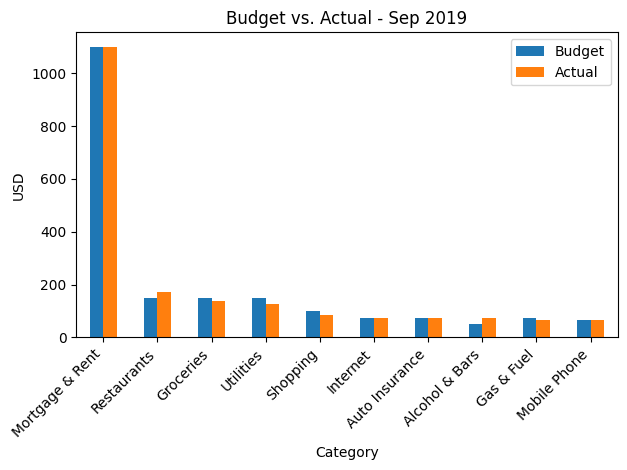

In [9]:
# Visualize Budget vs. Actual

import matplotlib.pyplot as plt

def plot_budget_vs_actual(rep, title):
  ax = rep.sort_values("Actual", ascending=False).head(10)[["Category", "Budget", "Actual"]].set_index("Category").plot(kind="bar")
  ax.set_title(title); ax.set_ylabel("USD"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

rep = month_report("2019-09")
plot_budget_vs_actual(rep, "Budget vs. Actual - Sep 2019")

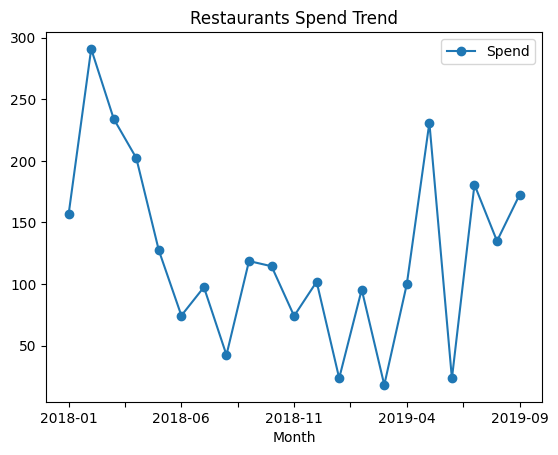

In [10]:
# Visualize Category Spend

def plot_trend(category):
  cat_tx = tx.groupby("Month")["Spend"].sum().reset_index()
  cat_tx = tx[tx["Category"] == category].groupby("Month")["Spend"].sum().reset_index()
  cat_tx.plot(x="Month", y="Spend", kind="line", marker="o", title=f"{category} Spend Trend")
plot_trend("Restaurants")

In [11]:
# Add yfinance for investments

# drop this in your "investments" section, replacing the old stock_summary
import time, yfinance as yf, pandas as pd

def _fetch_one_ticker(ticker, period="1y", interval="1d", retries=2, sleep=1.0):
    for a in range(retries + 1):
        try:
            df = yf.download(ticker, period=period, interval=interval,
                             auto_adjust=False, progress=False, threads=False)
            if df.empty or "Adj Close" not in df: return None
            s = df["Adj Close"].dropna()
            if s.empty: return None
            start = s.iloc[0].item()
            end   = s.iloc[-1].item()
            last_close = df["Close"].dropna().iloc[-1].item()

            ret = (end/start - 1) * 100
            return {"ticker": ticker, "start": start, "end": end,
                    "return_pct": ret, "last_close": last_close}
        except Exception as e:
            if a == retries:
                return {"ticker": ticker, "start": None, "end": None,
                        "return_pct": None, "last_close": None, "error": str(e)}
            time.sleep(sleep)

def stock_summary(tickers="SPY", period="1y", interval="1d"):
    if isinstance(tickers, str): tickers = [tickers]
    rows = [_fetch_one_ticker(t, period, interval) for t in tickers]
    rows = [r for r in rows if r is not None]
    if not rows:
        return pd.DataFrame(columns=["ticker","start","end","return_pct","last_close"])
    return pd.DataFrame(rows).sort_values("return_pct", ascending=False, na_position="last")


In [12]:
# Define summarize returns

def summarize_returns(results, period_label="1y"):
    print(f"\n--- Investment Summary for {period_label} ---\n")
    if results.empty:
        print("No data available."); return
    bad = results[results["return_pct"].isna()]
    good = results[results["return_pct"].notna()]
    for r in good.itertuples(index=False):
        print(f"{r.ticker}: {r.return_pct:,.2f}% "
              f"(Start ${r.start:,.2f} → End ${r.end:,.2f}; Last ${r.last_close:,.2f})")
    if not bad.empty:
        print("\n Skipped due to fetch error/timeouts:", ", ".join(bad["ticker"].tolist()))


In [13]:
# Add a router

import re
import matplotlib.pyplot as plt

def parse_month(text: str):
    m = re.search(r"(20\d{2}-\d{2})", text)  # YYYY-MM
    return m.group(1) if m else None

def parse_tickers(text: str):
    # grab UPPERCASE tokens 1-5 chars (very naive)
    toks = re.findall(r"\b[A-Z]{1,5}\b", text)
    ignore = {"USD", "ETF", "YTD", "YOY", "Q", "VS"}
    return [t for t in toks if t not in ignore] or None

def summarize_returns(results, period_label="1y"):
    print(f"\n--- Investment Summary for {period_label} ---\n")
    if results.empty:
        print("No data available."); return
    bad = results[results["return_pct"].isna()]
    good = results[results["return_pct"].notna()]
    for r in good.itertuples(index=False):
        print(f"{r.ticker}: {r.return_pct:,.2f}% "
              f"(Start ${r.start:,.2f} → End ${r.end:,.2f}; Last ${r.last_close:,.2f})")
    if not bad.empty:
        print("\n Skipped due to fetch error/timeouts:", ", ".join(bad["ticker"].tolist()))

def ask(q: str):
    ql = q.lower()

    # route to budget
    if any(k in ql for k in ["budget", "spend", "over budget", "under budget", "variance", "category"]):
        month = parse_month(q) or (tx.groupby("Month")["Spend"].sum().pipe(lambda s: s[s > 0]).index.max())
        rep = month_report(month)
        display(rep.head(10))
        budget_summary(rep, month_label=month)  # <-- no need to call human_month here
        return


    # route to stocks
    if any(k in ql for k in ["stock", "ticker", "price", "return", "market", "invest"]):
        tickers = parse_tickers(q) or ["SPY"]
        results = stock_summary(tickers, "1y")
        summarize_returns(results, "1y")

        valid = results[results["return_pct"].notna()]
        if not valid.empty:
            valid.set_index("ticker")["return_pct"].plot(kind="bar", title="1-Year Returns (%)")
            plt.ylabel("Return (%)")
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()
        return

,Category,Budget,Actual,Variance
0,Alcohol & Bars,50,72.98,22.98
15,Restaurants,150,172.34,22.34
1,Auto Insurance,75,75.00,0.00
12,Mortgage & Rent,1100,1100.00,0.00
3,Electronics & Software,0,0.00,0.00
11,Mobile Phone,65,65.00,0.00
10,Internet,75,75.00,0.00
13,Movies & DVDs,0,0.00,0.00
14,Music,11,10.69,-0.31
17,Television,15,13.90,-1.10


--- Budget Summary for September 2019 ---

Top over-budget categories:
  - Alcohol & Bars: +$22.98 (Actual $72.98 vs Budget $50.00)
  - Restaurants: +$22.34 (Actual $172.34 vs Budget $150.00)

Top under-budget categories:
  - Home Improvement: $-223.75 (Actual $26.25 vs Budget $250.00)
  - Haircut: $-30.00 (Actual $0.00 vs Budget $30.00)
  - Entertainment: $-25.00 (Actual $0.00 vs Budget $25.00)
  - Utilities: $-25.00 (Actual $125.00 vs Budget $150.00)
  - Fast Food: $-15.00 (Actual $0.00 vs Budget $15.00)

--- Investment Summary for 1y ---

MSFT: 23.11% (Start $410.41 → End $505.24; Last $505.24)
AAPL: 0.64% (Start $226.13 → End $227.57; Last $227.57)


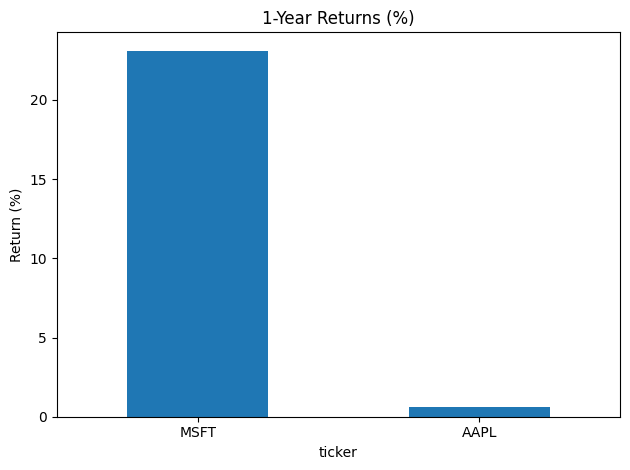

,Category,Budget,Actual,Variance
0,Alcohol & Bars,50,72.98,22.98
15,Restaurants,150,172.34,22.34
1,Auto Insurance,75,75.00,0.00
12,Mortgage & Rent,1100,1100.00,0.00
3,Electronics & Software,0,0.00,0.00
11,Mobile Phone,65,65.00,0.00
10,Internet,75,75.00,0.00
13,Movies & DVDs,0,0.00,0.00
14,Music,11,10.69,-0.31
17,Television,15,13.90,-1.10


--- Budget Summary for September 2019 ---

Top over-budget categories:
  - Alcohol & Bars: +$22.98 (Actual $72.98 vs Budget $50.00)
  - Restaurants: +$22.34 (Actual $172.34 vs Budget $150.00)

Top under-budget categories:
  - Home Improvement: $-223.75 (Actual $26.25 vs Budget $250.00)
  - Haircut: $-30.00 (Actual $0.00 vs Budget $30.00)
  - Entertainment: $-25.00 (Actual $0.00 vs Budget $25.00)
  - Utilities: $-25.00 (Actual $125.00 vs Budget $150.00)
  - Fast Food: $-15.00 (Actual $0.00 vs Budget $15.00)


In [14]:
ask("Where am I over budget in 2019-09?")
ask("Compare AAPL and MSFT returns over 1y")
ask("What is my total spend last month?")


In [17]:
# Create knowledge base

%%bash
mkdir -p /content/FinAssist/kb # Create directory if it doesn't exist
cat > /content/FinAssist/kb/finance_guide.md << 'EOF' # Budgeting tips & reference

## 50/30/20 Rule
Allocate 50% needs (rent, utilities), 30% wants (restaurants, entertainment), 20% savings/debt payoff.

## Lowering restaurant spend
- Set a weekly cap and track it.
- Meal prep 2 lunches/wk to cut impulse orders.
- Move coffee/fast food into a shared "Dining Out" cap.

## Groceries vs. Dining
- Groceries up + dining up → overbuying & eating out. Plan meals, shop with list.
- Groceries up + dining down → home cooking trend; check waste/spoilage.

## Mobile & Internet Bills
- Call the provider every 6-12 months for promo pricing.
- Bundle or auto-pay discounts can save 5-15%

## Emergency Fund
- Target 3-6 months expenses. Automate transfers the day after payday.

## Credit Card Payments
- Treat as transfers; don't double count as spend.

## Variance Interpretation
- Variance = Actual - Budget. Positive = over-budget; negative = under.
- Largest positive variance categories are best savings targets.

## Investment Basics
- Diversified index funds for long horizons.
- Compare 1y return to SPY as a quick benchmark.
EOF

In [28]:
# Create RAG helper module

%%bash
cat > /content/FinAssist/finassist/rag.py << 'EOF'
import os, re, pickle
from typing import List, Tuple
from sentence_transformers import SentenceTransformer # Corrected typo here
import numpy as np

KB_PATH = "/content/FinAssist/kb/finance_guide.md"
EMB_PATH = "/content/FinAssist/kb/embeddings.pkl"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

def _load_chunks(path: str, max_len=800) -> List[str]:
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
    parts = re.split(r"\n#{1,6}\s.*\n|^\s*$", text, flags=re.MULTILINE)
    parts = [p.strip() for p in parts if p and p.strip()]
    chunks, buf = [], ""
    for p in parts:
        if len(buf) + len(p) + 1 <= max_len:
            buf = (buf + "\n" + p).strip()
        else:
            if buf: chunks.append(buf)
            buf = p
    if buf: chunks.append(buf)
    return chunks

def _embed_chunks(chunks: List[str]):
    model = SentenceTransformer(MODEL_NAME)
    return model.encode(chunks, normalize_embeddings=True, show_progress_bar=False)

def _ensure_index():
    os.makedirs(os.path.dirname(EMB_PATH), exist_ok=True)
    if os.path.exists(EMB_PATH):
        with open(EMB_PATH, "rb") as f:
            data = pickle.load(f)
        if data.get("model") == MODEL_NAME and os.path.exists(KB_PATH):
            return data["chunks"], data["emb"]
    chunks = _load_chunks(KB_PATH)
    emb = _embed_chunks(chunks)
    with open(EMB_PATH, "wb") as f:
        pickle.dump({"chunks": chunks, "emb": emb, "model": MODEL_NAME}, f)
    return chunks, emb

def _search(query: str, k=3) -> List[Tuple[str, float]]:
    chunks, emb = _ensure_index()
    model = SentenceTransformer(MODEL_NAME)
    qv = model.encode([query], normalize_embeddings=True, show_progress_bar=False)[0]
    sims = emb @ qv
    idx = np.argsort(-sims)[:k]
    return [(chunks[i], float(sims[i])) for i in idx]

SYSTEM = (
    "You are FinAssist. Use the provided context to answer succinctly with "
    "actionable steps and dollar examples when relevant. If the context is "
    "insufficient, say you don’t know."
)

def _keywordize(text: str):
    return set(re.findall(r"[a-zA-Z]{3,}", text.lower()))

def _extract_bullets(context: str):
    lines = [ln.strip(" -•\t") for ln in context.splitlines()]
    # Keep non-empty bullets/short lines
    return [ln for ln in lines if ln and (ln.startswith(("-", "•")) or len(ln) <= 120)]

def _score_line(line: str, qwords: set):
    lw = _keywordize(line)
    # Jaccard-ish overlap + small length bonus (shorter is better)
    overlap = len(lw & qwords)
    return overlap + (0.2 if len(line) <= 100 else 0)

def _dollar_examples(line: str, q: str):
    ql = q.lower()
    # Add tiny, safe, generic dollar examples
    if any(k in ql for k in ["restaurant", "dining", "fast food", "coffee"]):
        if "cap" in line or "track" in line:
            return line + " (e.g., set a weekly dining cap of $40–$60 and track spend)."
        if "meal prep" in line:
            return line + " (two lunches/week could save ~$20–$30)."
    if "internet" in ql or "mobile" in ql or "phone" in ql:
        if "promo" in line or "provider" in line:
            return line + " (ask for promo pricing; $5–$20/mo savings is common)."
        if "auto-pay" in line or "bundle" in line:
            return line + " (bundles/auto-pay often save 5–15%, e.g., $5–$15/mo)."
    if "50/30/20" in q.lower():
        return "Allocate ~50% to needs, 30% to wants, 20% to savings/debt (e.g., on $3,000 take-home: $1,500 needs / $900 wants / $600 savings)."
    return line

def _make_answer(question: str, context: str, k_keep=5):
    qwords = _keywordize(question)
    bullets = _extract_bullets(context)
    if not bullets:
        # fall back to short paragraph from context
        para = context.split("\n\n")[0].strip()
        return para[:600] + ("..." if len(para) > 600 else "")

    scored = sorted(
        ((ln, _score_line(ln, qwords)) for ln in bullets),
        key=lambda t: t[1],
        reverse=True,
    )
    # Dedup near-duplicates by lowercase
    seen, picked = set(), []
    for ln, _ in scored:
        key = ln.lower()
        if key in seen:
            continue
        seen.add(key)
        picked.append(_dollar_examples(ln, question))
        if len(picked) >= k_keep:
            break

    # Ensure at least something direct if asking definition-like question
    if "50/30/20" in question.lower() and not any("50%" in p or "50/30/20" in p for p in picked):
        picked.insert(0, _dollar_examples("", question))

    # Format
    out = [f"**Answer:** {question.strip()}"]
    for p in picked:
        # re-add nice bullets
        out.append(f"• {p.lstrip('•- ')}")
    out.append("\n_Source: FinAssist KB_")
    return "\n".join(out)

def rag_answer(question: str, k: int = 3) -> str:
    hits = _search(question, k=k)
    if not hits:
        return "I don’t have enough info to answer that."
    # Concatenate top-k chunks
    context = "\n\n---\n\n".join([c for c, _ in hits])
    return _make_answer(question, context, k_keep=5)

bash: line 131: warning: here-document at line 1 delimited by end-of-file (wanted `EOF')


In [25]:
# Import and Extend Router

import sys
sys.path.append("/content/FinAssist")

from finassist.rag import rag_answer

def parse_period(text, default="1y"):
    m = re.search(r"\b(\d+[dwmy])\b", text.lower())
    if m: return m.group(1)
    if "ytd" in text.lower(): return "ytd"
    return default

def ask(q: str):
    ql = q.lower()

    # Budget
    if any(k in ql for k in ["budget","spend","over budget","under budget","variance","category"]):
        month = parse_month(q) or (tx.groupby("Month")["Spend"].sum().pipe(lambda s: s[s>0]).index.max())
        rep = month_report(month)
        display(rep.head(10))
        budget_summary(rep, month_label=month)
        return

    # Stocks
    if any(k in ql for k in ["stock","ticker","price","return","market","invest"]):
        tickers = parse_tickers(q) or ["SPY"]
        period = parse_period(q, "1y")
        results = stock_summary(tickers, period)
        summarize_returns(results, period)
        valid = results[results["return_pct"].notna()]
        if not valid.empty:
            valid.set_index("ticker")["return_pct"].plot(kind="bar", title=f"{period.upper()} Returns (%)")
            plt.ylabel("Return (%)"); plt.xticks(rotation=0); plt.tight_layout(); plt.show()
        return

    # RAG (how/tips/explain/what is/rule)
    if any(k in ql for k in ["how","tips","should i","explain","what is","rule"]):
        print(rag_answer(q, k=3))
        return

    print("Try:\n • Where am I over budget in 2019-09?\n • Compare AAPL and MSFT over 1y\n • How can I reduce restaurant spending?")

In [26]:
# Quick Test

ask("How can I reduce restaurant spending?")
ask("What is the 50/30/20 rule?")
ask("Any tips to lower my internet bill?")

,Category,Budget,Actual,Variance
0,Alcohol & Bars,50,72.98,22.98
15,Restaurants,150,172.34,22.34
1,Auto Insurance,75,75.00,0.00
12,Mortgage & Rent,1100,1100.00,0.00
3,Electronics & Software,0,0.00,0.00
11,Mobile Phone,65,65.00,0.00
10,Internet,75,75.00,0.00
13,Movies & DVDs,0,0.00,0.00
14,Music,11,10.69,-0.31
17,Television,15,13.90,-1.10


--- Budget Summary for September 2019 ---

Top over-budget categories:
  - Alcohol & Bars: +$22.98 (Actual $72.98 vs Budget $50.00)
  - Restaurants: +$22.34 (Actual $172.34 vs Budget $150.00)

Top under-budget categories:
  - Home Improvement: $-223.75 (Actual $26.25 vs Budget $250.00)
  - Haircut: $-30.00 (Actual $0.00 vs Budget $30.00)
  - Entertainment: $-25.00 (Actual $0.00 vs Budget $25.00)
  - Utilities: $-25.00 (Actual $125.00 vs Budget $150.00)
  - Fast Food: $-15.00 (Actual $0.00 vs Budget $15.00)
You are FinAssist. Use the provided context to answer succinctly with actionable steps and dollar examples when relevant. If the context is insufficient, say you don’t know.

Context:
Allocate 50% needs (rent, utilities), 30% wants (restaurants, entertainment), 20% savings/debt payoff.
- Set a weekly cap and track it.
- Meal prep 2 lunches/wk to cut impulse orders.
- Move coffee/fast food into a shared "Dining Out" cap.
- Groceries up + dining up → overbuying & eating out. Plan meals